In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("../data/processed/train_set.csv")
df


,Tanggal,RH_avg
0,01-01-2010,85
1,02-01-2010,83
2,03-01-2010,86
3,04-01-2010,84
4,05-01-2010,80
...,...,...
4083,23-04-2021,84
4084,24-04-2021,89
4085,25-04-2021,84
4086,26-04-2021,80


In [4]:
min_max_scaler = MinMaxScaler()
df["RH_avg"] = min_max_scaler.fit_transform(df[["RH_avg"]])
df.head()

,Tanggal,RH_avg
0,01-01-2010,0.68750
1,02-01-2010,0.62500
2,03-01-2010,0.71875
3,04-01-2010,0.65625
4,05-01-2010,0.53125


In [5]:
dates = df["Tanggal"].values
humidity = df["RH_avg"].values

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
train_set = windowed_dataset(humidity, window_size=60, batch_size=100, shuffle_buffer=1000)

In [14]:
cnn_model = tf.keras.models.Sequential([
    Conv1D(64, kernel_size=2, activation="relu", input_shape=[60, 1]),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=2, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(1),
])

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
cnn_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer=optimizer,
                  metrics=[MeanSquaredError(), RootMeanSquaredError()])

In [16]:
history_cnn = cnn_model.fit(train_set, epochs=10)

Epoch 1/10
41/41 [==============================] - 2s 19ms/step - loss: 0.1870 - mean_squared_error: 0.0571 - root_mean_squared_error: 0.2389
Epoch 2/10
41/41 [==============================] - 1s 15ms/step - loss: 0.1253 - mean_squared_error: 0.0251 - root_mean_squared_error: 0.1586
Epoch 3/10
41/41 [==============================] - 1s 15ms/step - loss: 0.1217 - mean_squared_error: 0.0239 - root_mean_squared_error: 0.1545
Epoch 4/10
41/41 [==============================] - 1s 18ms/step - loss: 0.1209 - mean_squared_error: 0.0236 - root_mean_squared_error: 0.1535
Epoch 5/10
41/41 [==============================] - 1s 16ms/step - loss: 0.1201 - mean_squared_error: 0.0235 - root_mean_squared_error: 0.1532
Epoch 6/10
41/41 [==============================] - 1s 15ms/step - loss: 0.1184 - mean_squared_error: 0.0229 - root_mean_squared_error: 0.1513
Epoch 7/10
41/41 [==============================] - 1s 15ms/step - loss: 0.1177 - mean_squared_error: 0.0226 - root_mean_squared_error: 0.1504

In [17]:
forecast = cnn_model.evaluate(train_set)
forecast

41/41 [==============================] - 1s 19ms/step - loss: 0.1159 - mean_squared_error: 0.0221 - root_mean_squared_error: 0.1485


[0.11594395339488983, 0.022050034254789352, 0.14849254488945007]

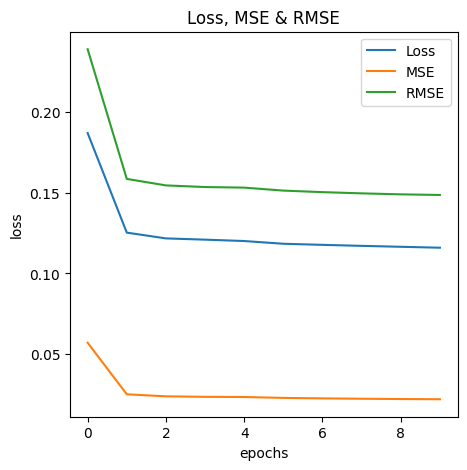

In [19]:
plt.figure(figsize=(5, 5))
plt.plot(history_cnn.history["loss"])
plt.plot(history_cnn.history["mean_squared_error"])
plt.plot(history_cnn.history["root_mean_squared_error"])
plt.title("Loss, MSE & RMSE")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["Loss", "MSE", "RMSE"], loc="best")
plt.show()

In [20]:
cnn_model.save("../models/cnn_model")

INFO:tensorflow:Assets written to: ../models/cnn_model\assets


INFO:tensorflow:Assets written to: ../models/cnn_model\assets


In [21]:
model = tf.keras.models.load_model("../models/cnn_model")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 59, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 29, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 28, 64)            8256      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 896)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              